In [1]:

%load_ext autotime

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [2]:
import numpy as np

time: 125 ms (started: 2025-01-29 00:44:47 +08:00)


In [3]:
seed=42
target_bit_width = 8
np.random.seed(seed)

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [4]:
class Quantizer:
    """量化器的base类"""
    def __init__(self):
        self.bit_width = target_bit_width
        self.max_value = 2 ** (target_bit_width - 1) - 1
        self.min_value = -2 ** (target_bit_width - 1)
    def compress(self, data):
        raise NotImplementedError
    def decompress(self, compressed_data):
        raise NotImplementedError

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [5]:
class AbsQuantizer(Quantizer):
    """绝对值量化器"""
    
    def compress(self, data):
        scale=np.divide(self.max_value, np.max(np.abs(data)))
        self.scale=scale
        return np.round(np.multiply(data, scale)).astype(np.int8)
    
    def decompress(self, compressed_data):
        return  np.divide(compressed_data, self.scale).astype(np.float32)

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [6]:
class BiasQuantizer(Quantizer):
    """偏置量化器"""
    
    def compress(self, data):
        scale=np.divide(self.max_value-self.min_value, np.max(data)-np.min(data))
        self.scale=scale
        bias=-scale*np.min(data)+self.min_value
        self.bias=bias
        return np.round(np.multiply(data, scale)+bias).astype(np.int8)
    
    def decompress(self, compressed_data):
        return  np.divide(compressed_data-self.bias, self.scale).astype(np.float32)

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [7]:
class OutlierQuantizer(Quantizer):
    """
        离群点量化器，以均值5倍标准差为判断标准来映射数据，多余的点视为离群点直接取最大的值
    """
    def compress(self, data):
        mean = np.mean(data)
        std = np.std(data)
        max_value = mean + 5 * std
        min_value = mean - 5 * std
        data = np.clip(data, min_value, max_value)
        scale=np.divide(self.max_value-self.min_value, np.max(data)-np.min(data))
        bias=-scale*np.min(data)+self.min_value
        self.scale=scale
        self.bias=bias
        return np.round(np.multiply(data, scale)+bias).astype(np.int8)    
    def decompress(self, compressed_data):
        return  np.divide(compressed_data-self.bias, self.scale).astype(np.float32)

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [8]:
def test_quantizer(quantizer, data,loss_func:str="mse"):
    compressed_data = quantizer.compress(data)
    decompressed_data = quantizer.decompress(compressed_data)
    # print("data: ", data[0])
    # print("compressed_data: ", compressed_data[:10])
    # print("decompressed_data: ", decompressed_data[0])
    if loss_func=="mse":
        loss = np.mean((data - decompressed_data) ** 2)
        # print("mse loss: ", loss)
        return loss
    

time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


In [9]:
class DataGenerator():
    #使用五个均值和方差都随机的正太分布组装分布
    def generate(self, seed=42):
        np.random.seed(seed)
        means=np.random.randint(-100,100,5)
        stds=np.random.randint(1,100,5)
        datas=[np.random.normal(mean,std,1000) for mean,std in zip(means,stds)]
        data=np.sum(datas,axis=0)
        return data






time: 15 ms (started: 2025-01-29 00:44:47 +08:00)


In [10]:
#0:绝对值量化器 1:偏置量化器 2:离群点量化器 
Quantizers=[AbsQuantizer(),BiasQuantizer(),OutlierQuantizer()]
seeds=range(10)
datas=[DataGenerator().generate(seed) for seed in seeds]
losses=[]
for data in datas:
    mse_losses=[]
    for quantizer in Quantizers:
        mse_loss=test_quantizer(quantizer, data)
        mse_losses.append(mse_loss)
    losses.append(mse_losses)
print("mse_losses: ", losses)

mse_losses:  [[1.53436625594094, 0.8909978094086369, 0.8909978094086369], [0.7687408647053299, 0.6863780440369206, 0.6863780440369206], [1.7360935731555251, 0.8246231082894205, 0.8246231082894205], [0.8265463259582189, 0.5597754552316597, 0.5597754552316597], [3.93421925595168, 1.3962817887041035, 1.3962817887041035], [1.7845054047407878, 0.8965943953380086, 0.8965943953380086], [1.9365457021397399, 1.2169501104007778, 1.2169501104007778], [1.490504326336354, 0.9518480751379139, 0.9518480751379139], [2.5600954698047853, 1.5645006912635084, 1.5645006912635084], [0.8113615299674852, 0.5779864663351375, 0.5779864663351375]]
time: 0 ns (started: 2025-01-29 00:44:47 +08:00)


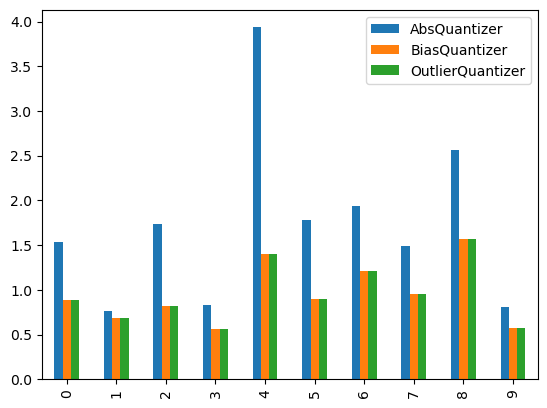

time: 1.69 s (started: 2025-01-29 00:45:22 +08:00)


In [11]:
#构造图表
import matplotlib.pyplot as plt
import pandas as pd
df=pd.DataFrame(losses,columns=["AbsQuantizer","BiasQuantizer","OutlierQuantizer"])
df.plot(kind='bar')
plt.show()

## 初步结论
对于这种相对规范的没什么离群点的数据，采用bias 线性量化就足够好了，outlier 线性量化器与bias的差别关键在于对离群范围的设置上，在这种随便用正态分布合成的相对规整的数据上二者表现相近,但是后者相当于多了个调超参的过程。

## 不足
测试数据与实际情况不符，需要进一步的实验